In [1]:
import argparse
from datetime import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch


from fireworks import LaunchPad
from jobflow import JobStore
from jobflow.managers.fireworks import flow_to_workflow
from maggma.stores.mongolike import MongoStore
from NanoParticleTools.flows.flows import get_npmc_flow
from NanoParticleTools.inputs.nanoparticle import SphericalConstraint
import uuid

from botorch.models import SingleTaskGP, ModelListGP
from botorch import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.optim import optimize_acqf

from common import seed_generator, configs

from common.utils import get_int, get_qe
from common import utils


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


In [2]:
def get_data_botorch(data_file, from_cloud = True):
    if from_cloud:
        df = gcloud_utils.get_df_gspread(GSPREAD_CRED, GSPREAD_NAME)
        #df = df.drop(labels=range(1, 600), axis=0)
        my_data = df.to_numpy()
        print(f"reading data log from google sheet: {GSPREAD_NAME}!")
    else:
        my_data = np.loadtxt(data_file, delimiter=',', skiprows=1)
        print(f"reading data log from local: {data_file}!")

    # features
    train_x = torch.from_numpy(my_data[:, :5])
    # labels
    train_y = torch.from_numpy(my_data[:, 5]).unsqueeze(-1)
    # best observation
    best_y = train_y.max().item()
    
    return train_x, train_y, best_y


def encode_inputs(x_arr, x_max = 34):
    '''encode simulation input to botorch'''
    for i, arr in enumerate(x_arr):
        x_arr[i, 0] = arr[0] + arr[1]
        if arr[0] + arr[1] == 0:
            x_arr[i, 1] = 0.5
        else:
            x_arr[i, 1] = arr[0] / (arr[0] + arr[1])
        x_arr[i, 2] = arr[2] + arr[3]
        if arr[2] + arr[3] == 0:
            x_arr[i, 3] = 0.5
        else:
            x_arr[i, 3] = arr[2] / (arr[2] + arr[3])
        x_arr[i, 4] = arr[4] / x_max


def decode_candidates(x_arr, x_max = 34):
    '''decode botorch recommendation candidates for simulation'''
    for i, arr in enumerate(x_arr):
        x_arr[i, 0], x_arr[i, 1] = arr[0] * arr[1], arr[0] * (1 - arr[1])
        x_arr[i, 2], x_arr[i, 3] = arr[2] * arr[3], arr[2] * (1 - arr[3])
        x_arr[i, 4] = arr[4] * x_max

def recommend(train_x, train_y, best_y, bounds, n_trails = 5):
    if isinstance(bounds, list):
        bounds = torch.tensor(bounds)
    elif torch.is_tensor(bounds):
        pass
    else:
        raise TypeError(f"expect bounds in a list or tensor. was given {type(bounds)}")
    
    single_model = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    
    # Expected Improvement acquisition function
    EI = qExpectedImprovement(model = single_model, best_f = best_y)
    # Upper Confidence Bound acquisition function
    UCB = UpperConfidenceBound(single_model, beta=100)
    
    # hyperparameters are super sensitive here
    candidates, _ = optimize_acqf(acq_function = UCB,
                                 bounds = bounds, 
                                 q = n_trails, 
                                 num_restarts = 20, 
                                 raw_samples = 512, 
                                # options = {'batch_limit': 5, "maxiter": 200}
                                 )
    
    return candidates

# Optimization analysis

In [138]:
# use this for data saved in cloud
from common import gcloud_utils
GSPREAD_CRED = './common/sustained-spark-354104-2f5a40769608.json'
GSPREAD_NAME = 'simulation_log.csv'
df = gcloud_utils.get_df_gspread(GSPREAD_CRED, GSPREAD_NAME)
#df.sort_values(by='VIS', ascending=False).head(10)

In [3]:
#  use this for local data
DATA_DEST = "../saved_data/simulation_log_YbErTm.csv"
# DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test2.csv"
df = pd.read_csv(DATA_DEST)
#df_0p5 = pd.read_csv(DATA_DEST2)

In [116]:
id_start = 640
yb1_mean = round(np.mean(df[id_start:]['yb_1']),4)
yb1_std = round(np.std(df[id_start:]['yb_1']),4)
er1_mean = round(np.mean(df[id_start:]['er_1']),4)
er1_std = round(np.std(df[id_start:]['er_1']),4)
yb2_mean = round(np.mean(df[id_start:]['yb_2']),4)
yb2_std = round(np.std(df[id_start:]['yb_2']),4)
er2_mean = round(np.mean(df[id_start:]['er_2']),4)
er2_std = round(np.std(df[id_start:]['er_2']),4)
radius_mean = round(np.mean(df[id_start:]['radius']),4)
radius_std = round(np.std(df[id_start:]['radius']),4)

print(f'yb_1: {yb1_mean}+/-{yb1_std}')
print(f'er_1: {er1_mean}+/-{er1_std}')
print(f'yb_2: {yb2_mean}+/-{yb2_std}')
print(f'er_2: {er2_mean}+/-{er2_std}')
print(f'radius: {radius_mean}+/-{radius_std}')


yb_1: 0.7267+/-0.0008
er_1: 0.0039+/-0.0002
yb_2: 0.0+/-0.0
er_2: 0.0+/-0.0
radius: 22.1991+/-0.0065


In [104]:
round(np.mean(df[635:]['yb_1']),4)

3.9476

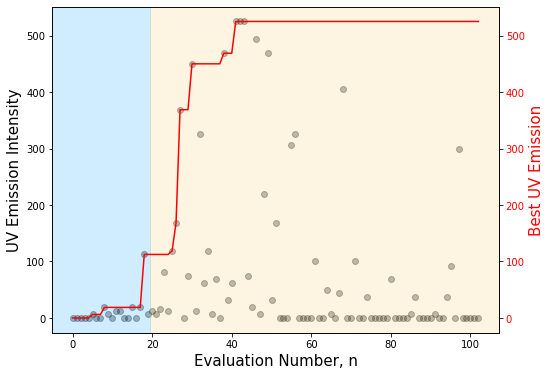

In [4]:
import matplotlib.pyplot as plt

# plot single result
evalued = len(df)
max_uv = []
y = df.UV
for i in range(evalued):
    max_uv.append(df.iloc[0:i+1].UV.max())
x = range(len(max_uv))   

fig, ax1 = plt.subplots(figsize=(8, 6))

ax2 = ax1.twinx()
ax1.scatter(x, y, c='black', alpha = 0.3)
ax2.plot(x, max_uv, c='r', alpha = 1)

FontSize = 15
ax1.set_ylim(-max(y)*0.05,max(y)*1.05)
ax2.set_ylim(-max(y)*0.05,max(y)*1.05)
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission', color='r', fontsize = FontSize)
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 19.5, color='#00A1FF', alpha=0.19)
plt.axvspan(19.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
# plt.axvspan(x[0]-x[-1]*0.05, 399.5, color='#00A1FF', alpha=0.19)
# plt.axvspan(399.5, 619.5, color='purple', alpha=0.19)
# plt.axvspan(619.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()

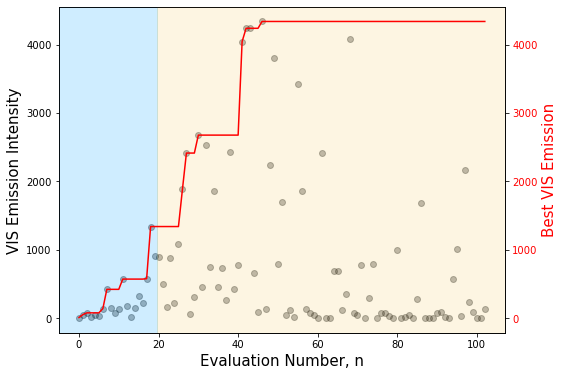

In [5]:
import matplotlib.pyplot as plt

# plot single result
evalued = len(df)
max_uv = []
y = df.VIS
for i in range(evalued):
    max_uv.append(df.iloc[0:i+1].VIS.max())
x = range(len(max_uv))   

fig, ax1 = plt.subplots(figsize=(8, 6))

ax2 = ax1.twinx()
ax1.scatter(x, y, c='black', alpha = 0.3)
ax2.plot(x, max_uv, c='r', alpha = 1)

FontSize = 15
ax1.set_ylim(-max(y)*0.05,max(y)*1.05)
ax2.set_ylim(-max(y)*0.05,max(y)*1.05)
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('VIS Emission Intensity', fontsize = FontSize)
ax2.set_ylabel('Best VIS Emission', color='r', fontsize = FontSize)
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 19.5, color='#00A1FF', alpha=0.19)
plt.axvspan(19.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
# plt.axvspan(x[0]-x[-1]*0.05, 399.5, color='#00A1FF', alpha=0.19)
# plt.axvspan(399.5, 619.5, color='purple', alpha=0.19)
# plt.axvspan(619.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()

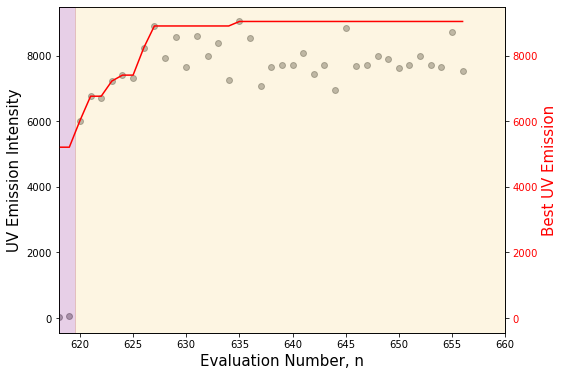

In [82]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax2 = ax1.twinx()
ax1.scatter(x, y, c='black', alpha = 0.3)
ax2.plot(x, max_uv, c='r', alpha = 1)

FontSize = 15
ax1.set_ylim(-max(y)*0.05,max(y)*1.05)
ax2.set_ylim(-max(y)*0.05,max(y)*1.05)
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission', color='r', fontsize = FontSize)
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 399.5, color='#00A1FF', alpha=0.19)
plt.axvspan(399.5, 619.5, color='purple', alpha=0.19)
plt.axvspan(619.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([618,660])
plt.show()

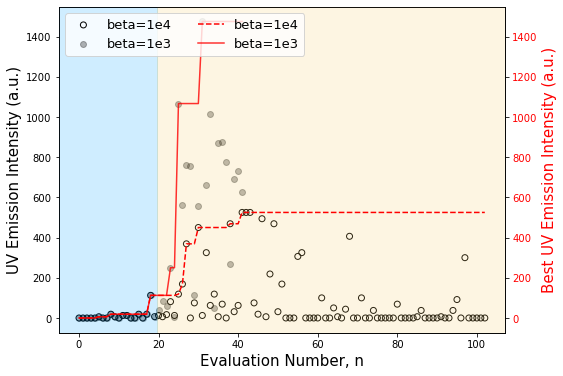

In [11]:
# optimization progress: result of each iteration and best results
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/simulation_log_YbErTm.csv"
DATA_DEST2 = "../saved_data/simulation_log_YbErTm_1e3.csv"
df = pd.read_csv(DATA_DEST)
df_0p5 = pd.read_csv(DATA_DEST2)

evalued = len(df)
max_uv = []
y = df.UV

evalued_2 = len(df_0p5)
max_uv_2 = []
y_2 = df_0p5.UV

for i in range(evalued):
    max_uv.append(df.iloc[0:i+1].UV.max())
x = range(len(max_uv))   

for i in range(evalued_2):
    max_uv_2.append(df_0p5.iloc[0:i+1].UV.max())
x_2 = range(len(max_uv_2)) 

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

s1=ax1.scatter(x, y, facecolors='none', edgecolors='black', alpha = 1, marker='o', label='beta=1e4')
l1=ax2.plot(x, max_uv, c='r', alpha = 1, linestyle='dashed',label='beta=1e4')
s2=ax1.scatter(x_2, y_2, c='black', alpha = 0.3, label='beta=1e3')
l2=ax2.plot(x_2, max_uv_2, c='r', alpha = 0.8, label='beta=1e3')

FontSize = 15

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', ncol=2, fontsize = 13, frameon = True)


ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity (a.u.)', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission Intensity (a.u.)', color='r', fontsize = FontSize)

#ax2.tick_params(axis='y', color='r')
#ax2.spines['right'].set_color('red') 
#plt.setp(ax2.get_yticklabels(), visible=False)
x = range(max(len(x),len(x_2)))
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 19.5, color='#00A1FF', alpha=0.19)
plt.axvspan(19.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


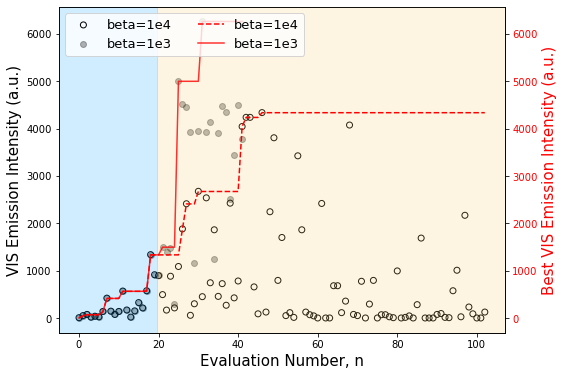

In [12]:
# optimization progress: result of each iteration and best results
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/simulation_log_YbErTm.csv"
DATA_DEST2 = "../saved_data/simulation_log_YbErTm_1e3.csv"
df = pd.read_csv(DATA_DEST)
df_0p5 = pd.read_csv(DATA_DEST2)

evalued = len(df)
max_uv = []
y = df.VIS

evalued_2 = len(df_0p5)
max_uv_2 = []
y_2 = df_0p5.VIS

for i in range(evalued):
    max_uv.append(df.iloc[0:i+1].VIS.max())
x = range(len(max_uv))   

for i in range(evalued_2):
    max_uv_2.append(df_0p5.iloc[0:i+1].VIS.max())
x_2 = range(len(max_uv_2)) 

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

s1=ax1.scatter(x, y, facecolors='none', edgecolors='black', alpha = 1, marker='o', label='beta=1e4')
l1=ax2.plot(x, max_uv, c='r', alpha = 1, linestyle='dashed',label='beta=1e4')
s2=ax1.scatter(x_2, y_2, c='black', alpha = 0.3, label='beta=1e3')
l2=ax2.plot(x_2, max_uv_2, c='r', alpha = 0.8, label='beta=1e3')

FontSize = 15

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', ncol=2, fontsize = 13, frameon = True)


ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('VIS Emission Intensity (a.u.)', fontsize = FontSize)
ax2.set_ylabel('Best VIS Emission Intensity (a.u.)', color='r', fontsize = FontSize)

#ax2.tick_params(axis='y', color='r')
#ax2.spines['right'].set_color('red') 
#plt.setp(ax2.get_yticklabels(), visible=False)
x = range(max(len(x),len(x_2)))
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 19.5, color='#00A1FF', alpha=0.19)
plt.axvspan(19.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


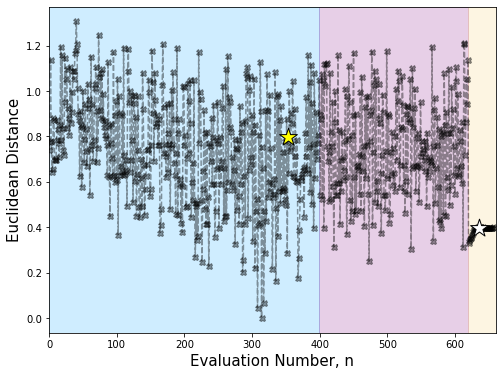

In [139]:
# Euclidean distance
def encode(arr, x_max = 34):
    x_arr = arr
    x_arr[0] = arr[0] + arr[1]
    if arr[0] + arr[1] == 0:
        x_arr[1] = 0.5
    else:
        x_arr[1] = arr[0] / (arr[0] + arr[1])
    x_arr[2] = arr[2] + arr[3]
    if arr[2] + arr[3] == 0:
        x_arr[3] = 0.5
    else:
        x_arr[3] = arr[2] / (arr[2] + arr[3])
    x_arr[4] = arr[4] / x_max
    return x_arr

def Euc_dist(X,Y):
    sum = 0
    for x, y in zip(X,Y):
        sum += (x-y)**2
    return np.sqrt(sum)
        
evalued1 = len(df)
distance_1 = []
for i in range(evalued1):
    temp = df.iloc[i].to_numpy()[:5].copy()
    temp = encode(temp)
    dist = Euc_dist(temp, best_init_1)
    distance_1.append(dist)

x_1 = range(len(df))
y = distance_1

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_1, y, linestyle='dashed', c='black', alpha = 0.4, marker='X',label='beta=100')
#ax1.legend(loc = 'upper left', ncol=1, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('Euclidean Distance', fontsize = FontSize)

# ax1.set_ylim(0,40)
x = range(max(len(x_1),len(x_2)))
plt.axvspan(x[0]-x[-1]*0.05, 399.5, color='#00A1FF', alpha=0.19)
plt.axvspan(399.5, 619.5, color='purple', alpha=0.19)
plt.axvspan(619.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([0,660])

# add best points
best_init = df.iloc[:619].UV.idxmax()
plt.scatter(x[best_init],y[best_init],marker='*',s=350,facecolors='yellow', edgecolors='black', zorder=3)
best_rec = df.iloc[620:].UV.idxmax()
plt.scatter(x[best_rec],y[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
plt.show()



In [142]:
df.iloc[best_rec-1]

yb_1               0.725410
er_1               0.004203
yb_2               0.000000
er_2               0.000000
radius            22.201403
UV              9049.999376
VIS             6137.499535
BLUE            1024.999923
GREEN           1037.499925
RED             1462.499873
TOTAL          16362.498870
ABSORPTION    116987.491600
qe                 0.022292
Name: 636, dtype: float64

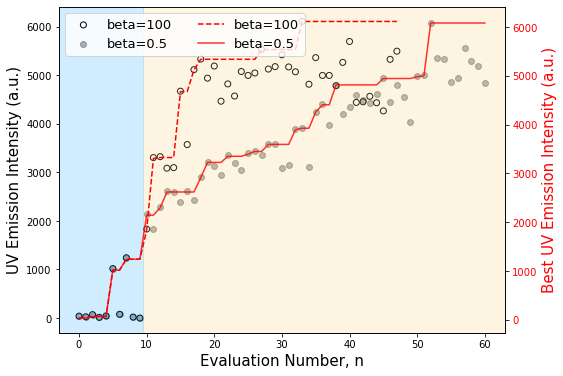

In [7]:
# optimization progress: result of each iteration and best results
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test1.csv"
df = pd.read_csv(DATA_DEST)
df_0p5 = pd.read_csv(DATA_DEST2)

evalued = len(df)
max_uv = []
y = df.UV

evalued_2 = len(df_0p5)
max_uv_2 = []
y_2 = df_0p5.UV

for i in range(evalued):
    max_uv.append(df.iloc[0:i+1].UV.max())
x = range(len(max_uv))   

for i in range(evalued_2):
    max_uv_2.append(df_0p5.iloc[0:i+1].UV.max())
x_2 = range(len(max_uv_2)) 

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

s1=ax1.scatter(x, y, facecolors='none', edgecolors='black', alpha = 1, marker='o', label='beta=100')
l1=ax2.plot(x, max_uv, c='r', alpha = 1, linestyle='dashed',label='beta=100')
s2=ax1.scatter(x_2, y_2, c='black', alpha = 0.3, label='beta=0.5')
l2=ax2.plot(x_2, max_uv_2, c='r', alpha = 0.8, label='beta=0.5')

FontSize = 15

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', ncol=2, fontsize = 13, frameon = True)


ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity (a.u.)', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission Intensity (a.u.)', color='r', fontsize = FontSize)

#ax2.tick_params(axis='y', color='r')
#ax2.spines['right'].set_color('red') 
#plt.setp(ax2.get_yticklabels(), visible=False)
x = range(max(len(x),len(x_2)))
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


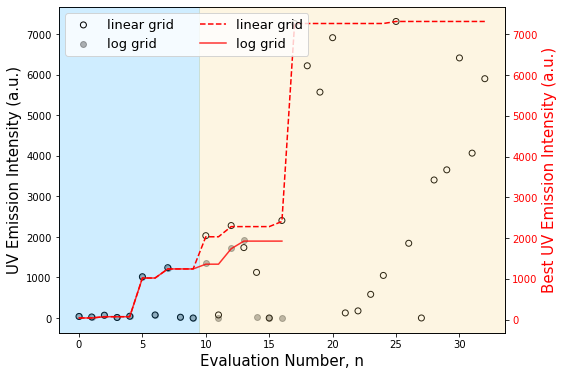

In [6]:
# optimization progress: result of each iteration and best results
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/UV_log_shuffled_10initial_test1_grid_beta=10000.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test1_loggrid_beta=10000.csv"
df = pd.read_csv(DATA_DEST)
df_0p5 = pd.read_csv(DATA_DEST2)

evalued = len(df)
max_uv = []
y = df.UV

evalued_2 = len(df_0p5)
max_uv_2 = []
y_2 = df_0p5.UV

for i in range(evalued):
    max_uv.append(df.iloc[0:i+1].UV.max())
x = range(len(max_uv))   

for i in range(evalued_2):
    max_uv_2.append(df_0p5.iloc[0:i+1].UV.max())
x_2 = range(len(max_uv_2)) 

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

s1=ax1.scatter(x, y, facecolors='none', edgecolors='black', alpha = 1, marker='o', label='linear grid')
l1=ax2.plot(x, max_uv, c='r', alpha = 1, linestyle='dashed',label='linear grid')
s2=ax1.scatter(x_2, y_2, c='black', alpha = 0.3, label='log grid')
l2=ax2.plot(x_2, max_uv_2, c='r', alpha = 0.8, label='log grid')

FontSize = 15

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', ncol=2, fontsize = 13, frameon = True)


ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity (a.u.)', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission Intensity (a.u.)', color='r', fontsize = FontSize)

#ax2.tick_params(axis='y', color='r')
#ax2.spines['right'].set_color('red') 
#plt.setp(ax2.get_yticklabels(), visible=False)
x = range(max(len(x),len(x_2)))
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


In [150]:
df_0p5.iloc[10:]

,yb_1,er_1,yb_2,er_2,radius,UV,VIS,BLUE,GREEN,RED,TOTAL,ABSORPTION,qe
10,0.703814,0.076095,0.060209,0.013141,29.0,1358.332990,4366.665542,499.999857,1624.999613,2041.666104,6224.998405,39191.656441,0.002339
11,0.000000,0.001000,0.000000,0.060209,5.0,0.000000,18.748910,0.000000,6.249919,12.498990,18.748910,106.197494,0.000311
12,0.703814,0.067688,0.042376,0.007318,29.0,1737.499704,5168.749166,718.749894,1681.249730,2424.999595,7293.748813,43893.742789,0.002820
13,0.703814,0.053557,0.033529,0.004582,29.0,1924.999644,5281.248982,749.999865,1693.749673,2487.499501,7549.998541,50443.739675,0.002984
14,0.626052,0.348637,0.016609,0.000000,5.0,12.499839,24.996540,0.000000,0.000000,12.496701,24.996540,6280.840291,0.000319
15,0.001000,0.000000,0.703814,0.000000,33.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1118.710691,0.000000
16,0.001000,0.000000,0.001000,0.000000,33.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,442.507732,0.000000


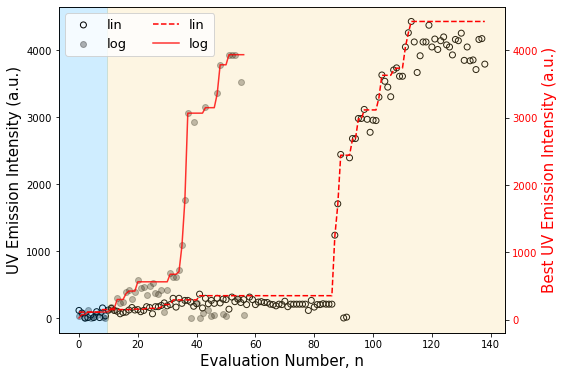

In [7]:
# optimization progress: result of each iteration and best results
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/UV_log_KS_10initial_linscale.csv"
DATA_DEST2 = "../saved_data/UV_log_KS_10initial_logscale.csv"
df = pd.read_csv(DATA_DEST)
df_0p5 = pd.read_csv(DATA_DEST2)

evalued = len(df)
max_uv = []
y = df.UV

evalued_2 = len(df_0p5)
max_uv_2 = []
y_2 = df_0p5.UV

for i in range(evalued):
    max_uv.append(df.iloc[0:i+1].UV.max())
x = range(len(max_uv))   

for i in range(evalued_2):
    max_uv_2.append(df_0p5.iloc[0:i+1].UV.max())
x_2 = range(len(max_uv_2)) 

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

s1=ax1.scatter(x, y, facecolors='none', edgecolors='black', alpha = 1, marker='o', label='lin')
l1=ax2.plot(x, max_uv, c='r', alpha = 1, linestyle='dashed',label='lin')
s2=ax1.scatter(x_2, y_2, c='black', alpha = 0.3, label='log')
l2=ax2.plot(x_2, max_uv_2, c='r', alpha = 0.8, label='log')

FontSize = 15

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', ncol=2, fontsize = 13, frameon = True)


ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity (a.u.)', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission Intensity (a.u.)', color='r', fontsize = FontSize)

#ax2.tick_params(axis='y', color='r')
#ax2.spines['right'].set_color('red') 
#plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


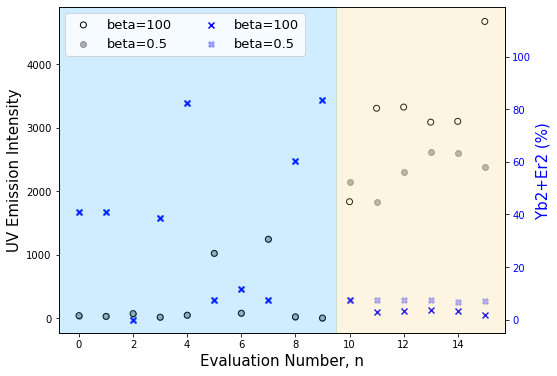

In [257]:
# optimization progress: recommended shell dopants
# to compare optimizations with the same initial dataset but different beta values
shell_sum = (df.yb_2+df.er_2)*100
shell_sum_2 = (df_0p5.yb_2+df_0p5.er_2)*100
y = df.UV
y_2 = df_0p5.UV
x = range(len(y))
x_2 = range(len(y_2))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

ax1.scatter(x, y, facecolors='none', edgecolors='black', alpha = 1, label='beta=100')
ax2.scatter(x, shell_sum, c='b', alpha = 1, marker='x', label='beta=100')
ax1.scatter(x_2, y_2, c='black', alpha = 0.3, label='beta=0.5')
ax2.scatter(x_2, shell_sum_2, c='b', alpha = 0.3, marker='X', label='beta=0.5')

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor =(0.6, 0.9), ncol=2, fontsize = 13, frameon = True)
ax2.legend(lines + lines2, labels + labels2, loc = 'upper left', ncol=2, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity', fontsize = FontSize)
ax2.set_ylabel('Yb2+Er2 (%)', color='b', fontsize = FontSize)
#ax2.tick_params(axis='y', color='r')
#ax2.spines['right'].set_color('red') 
#plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), color="b")
plt.ylim([-5,119])
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


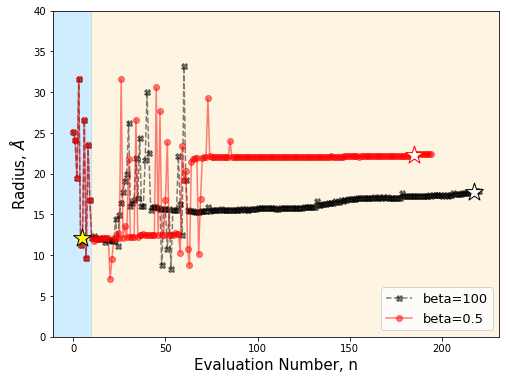

In [48]:
# optimization progress: recommended shell dopants
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/UV_log_shuffled_10initial_test2_beta=100.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test2.csv"
df = pd.read_csv(DATA_DEST)
df_0p5 = pd.read_csv(DATA_DEST2)

obj = 'radius'
y = df[obj]
y_2 = df_0p5[obj]
x_1 = range(len(y))
x_2 = range(len(y_2))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_1, y, linestyle='dashed', c='black', alpha = 0.5, marker='X',label='beta=100')
ax1.plot(x_2, y_2, linestyle='solid', c='r', alpha = 0.5, marker='o', label='beta=0.5')
ax1.legend(loc = 'lower right', ncol=1, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel(r'Radius, $\AA$', fontsize = FontSize)

ax1.set_ylim(0,40)
x = range(max(len(x_1),len(x_2)))
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])

# add best points
best_init = df.iloc[:10].UV.idxmax()
plt.scatter(x[best_init],y[best_init],marker='*',s=350,facecolors='yellow', edgecolors='black', zorder=3)
best_rec = df.iloc[10:].UV.idxmax()
plt.scatter(x[best_rec],y[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
best_rec_2 = df_0p5.iloc[10:].UV.idxmax()
plt.scatter(x_2[best_rec_2],y_2[best_rec_2],marker='*',s=350,facecolors='white', edgecolors='red', zorder=4)
plt.show()


In [119]:
df[-10:]

,yb_1,er_1,yb_2,er_2,radius,UV,VIS,BLUE,GREEN,RED,TOTAL,ABSORPTION,qe
40,0.694860,0.044463,0.006475,0.000600,26.464750,5699.999182,9499.998539,1374.999784,2674.999555,4281.249353,15693.747624,58387.491195,0.009256
41,0.694195,0.044110,0.006079,0.000555,26.442768,4443.749162,8312.498404,1293.749754,2512.499520,3649.999304,13537.497443,56874.989189,0.008062
42,0.696449,0.043830,0.006719,0.000606,26.533665,4456.249436,8256.248964,1281.249831,2256.249716,3918.749520,13393.748315,57337.492939,0.007754
43,0.693953,0.044238,0.007137,0.000634,26.383121,4568.749532,8168.749153,1268.749852,2449.999744,3562.499647,13443.748612,56443.744126,0.007988
44,0.709925,0.041781,0.007374,0.000650,26.964891,4437.499460,8137.498981,1349.999850,2518.749688,3462.499549,13199.998375,59893.742399,0.006996
45,0.653957,0.047285,0.007714,0.000867,26.455309,4268.749155,8374.998284,1324.999725,2537.499474,3637.499243,13118.747336,50487.490045,0.008089
46,0.701864,0.044338,0.007301,0.000638,26.490431,5331.248960,9043.748377,1462.499734,2693.749558,3893.749278,15062.497204,57899.989297,0.008765
47,0.740354,0.048219,0.008030,0.000597,25.717020,5499.999224,9418.748637,1474.999799,2749.999632,4012.499383,15356.247814,57431.241763,0.009065
48,0.753903,0.049671,0.008100,0.000572,25.418606,6162.498810,10387.497910,1724.999644,2874.999393,4593.749117,17124.996601,58231.238210,0.010105
49,0.773990,0.050331,0.008129,0.000519,25.078644,6137.499320,9881.248843,1593.749811,2912.499643,4206.249519,16837.498077,57099.993441,0.010265


In [123]:
id_start = -2

yb1_mean = round(np.mean(df[id_start:]['yb_1']),4)
yb1_std = round(np.std(df[id_start:]['yb_1']),4)
er1_mean = round(np.mean(df[id_start:]['er_1']),4)
er1_std = round(np.std(df[id_start:]['er_1']),4)
yb2_mean = round(np.mean(df[id_start:]['yb_2']),4)
yb2_std = round(np.std(df[id_start:]['yb_2']),4)
er2_mean = round(np.mean(df[id_start:]['er_2']),4)
er2_std = round(np.std(df[id_start:]['er_2']),4)
radius_mean = round(np.mean(df[id_start:]['radius']),4)
radius_std = round(np.std(df[id_start:]['radius']),4)

print(f'yb_1: {yb1_mean}+/-{yb1_std}')
print(f'er_1: {er1_mean}+/-{er1_std}')
print(f'yb_2: {yb2_mean}+/-{yb2_std}')
print(f'er_2: {er2_mean}+/-{er2_std}')
print(f'radius: {radius_mean}+/-{radius_std}')


yb_1: 0.7639+/-0.01
er_1: 0.05+/-0.0003
yb_2: 0.0081+/-0.0
er_2: 0.0005+/-0.0
radius: 25.2486+/-0.17


In [121]:
id_start = -10

yb1_mean = round(np.mean(df_0p5[id_start:]['yb_1']),4)
yb1_std = round(np.std(df_0p5[id_start:]['yb_1']),4)
er1_mean = round(np.mean(df_0p5[id_start:]['er_1']),4)
er1_std = round(np.std(df_0p5[id_start:]['er_1']),4)
yb2_mean = round(np.mean(df_0p5[id_start:]['yb_2']),4)
yb2_std = round(np.std(df_0p5[id_start:]['yb_2']),4)
er2_mean = round(np.mean(df_0p5[id_start:]['er_2']),4)
er2_std = round(np.std(df_0p5[id_start:]['er_2']),4)
radius_mean = round(np.mean(df_0p5[id_start:]['radius']),4)
radius_std = round(np.std(df_0p5[id_start:]['radius']),4)

print(f'yb_1: {yb1_mean}+/-{yb1_std}')
print(f'er_1: {er1_mean}+/-{er1_std}')
print(f'yb_2: {yb2_mean}+/-{yb2_std}')
print(f'er_2: {er2_mean}+/-{er2_std}')
print(f'radius: {radius_mean}+/-{radius_std}')

yb_1: 0.6761+/-0.0119
er_1: 0.0197+/-0.0014
yb_2: 0.0355+/-0.0012
er_2: 0.0012+/-0.0001
radius: 25.4532+/-0.0523


In [ ]:


best_rec = df.iloc[10:].UV.idxmax()
best_rec_2 = df_0p5.iloc[10:].UV.idxmax()


In [49]:
    df.iloc[best_rec]

yb_1              0.914359
er_1              0.024200
yb_2              0.000000
er_2              0.000000
radius           17.742771
UV             7231.248754
VIS            6874.998894
BLUE           1281.249799
GREEN          1349.999791
RED            2356.249622
TOTAL         14399.997621
ABSORPTION    47368.742281
qe                0.023702
Name: 217, dtype: float64

In [50]:
df_0p5.iloc[best_rec_2]


yb_1              0.648793
er_1              0.015075
yb_2              0.000026
er_2              0.000002
radius           22.349407
UV             8312.499205
VIS            8106.249223
BLUE           1493.749862
GREEN          1631.249830
RED            2662.499755
TOTAL         16862.498403
ABSORPTION    68674.993465
qe                0.019969
Name: 185, dtype: float64

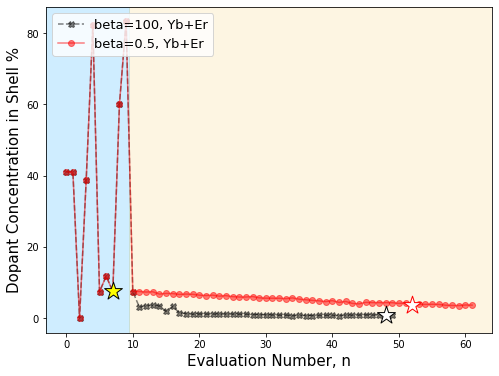

In [118]:
obj1 = 'yb_2'
obj2 = 'er_2'
y = (df[obj1]+df[obj2])*100
y_2 = (df_0p5[obj1]+df_0p5[obj2])*100
x_1 = range(len(y))
x_2 = range(len(y_2))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_1, y, linestyle='dashed', c='black', alpha = 0.5, marker='X',label='beta=100, Yb+Er')
ax1.plot(x_2, y_2, linestyle='solid', c='r', alpha = 0.5, marker='o', label='beta=0.5, Yb+Er')
ax1.legend(loc = 'upper left', ncol=1, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('Dopant Concentration in Shell %', fontsize = FontSize)

# ax1.set_ylim(0,40)
x = range(max(len(x_1),len(x_2)))
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])

# add best points
best_init = df.iloc[:10].UV.idxmax()
plt.scatter(x[best_init],y[best_init],marker='*',s=350,facecolors='yellow', edgecolors='black', zorder=3)
best_rec = df.iloc[10:].UV.idxmax()
plt.scatter(x[best_rec],y[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
best_rec_2 = df_0p5.iloc[10:].UV.idxmax()
plt.scatter(x_2[best_rec_2],y_2[best_rec_2],marker='*',s=350,facecolors='white', edgecolors='red', zorder=4)
plt.show()


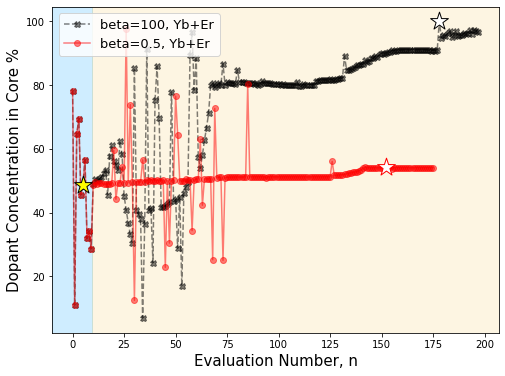

In [68]:
obj1 = 'yb_1'
obj2 = 'er_1'
y = (df[obj1]+df[obj2])*100
y_2 = (df_0p5[obj1]+df_0p5[obj2])*100
x_1 = range(len(y))
x_2 = range(len(y_2))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_1, y, linestyle='dashed', c='black', alpha = 0.5, marker='X',label='beta=100, Yb+Er')
ax1.plot(x_2, y_2, linestyle='solid', c='r', alpha = 0.5, marker='o', label='beta=0.5, Yb+Er')
ax1.legend(loc = 'upper left', ncol=1, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('Dopant Concentration in Core %', fontsize = FontSize)

# ax1.set_ylim(0,40)
x = range(max(len(x_1),len(x_2)))
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])

# add best points
best_init = df.iloc[:10].UV.idxmax()
plt.scatter(x[best_init],y[best_init],marker='*',s=350,facecolors='yellow', edgecolors='black', zorder=3)
best_rec = df.iloc[10:].UV.idxmax()
plt.scatter(x[best_rec],y[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
best_rec_2 = df_0p5.iloc[10:].UV.idxmax()
plt.scatter(x_2[best_rec_2],y_2[best_rec_2],marker='*',s=350,facecolors='white', edgecolors='red', zorder=4)

plt.show()

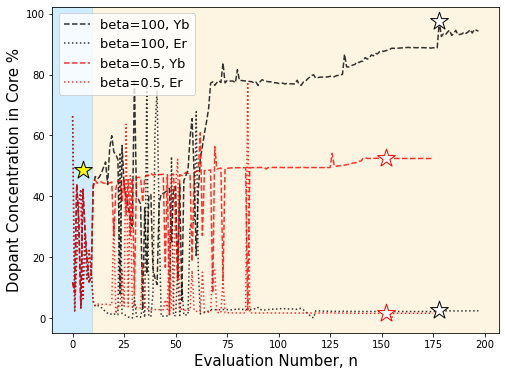

In [69]:
obj1 = 'yb_1'
obj2 = 'er_1'
y1_yb = df[obj1]*100
y1_er = df[obj2]*100
y2_yb = df_0p5[obj1]*100
y2_er = df_0p5[obj2]*100
x_1 = range(len(y))
x_2 = range(len(y_2))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_1, y1_yb, linestyle='dashed', c='black', alpha = 0.8, label='beta=100, Yb')
ax1.plot(x_1, y1_er, linestyle='dotted', c='black', alpha = 0.8,label='beta=100, Er')
ax1.plot(x_2, y2_yb, linestyle='dashed', c='r', alpha = 0.8, label='beta=0.5, Yb')
ax1.plot(x_2, y2_er, linestyle='dotted', c='r', alpha = 0.8,label='beta=0.5, Er')

ax1.legend(loc = 'upper left', ncol=1, fontsize = 13, frameon = True)



FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('Dopant Concentration in Core %', fontsize = FontSize)

# ax1.set_ylim(0,40)
x = range(max(len(x_1),len(x_2)))
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])

# add best points
best_init = df.iloc[:10].UV.idxmax()
plt.scatter(x[best_init],y[best_init],marker='*',s=350,facecolors='yellow', edgecolors='black', zorder=3)
best_rec = df.iloc[10:].UV.idxmax()
plt.scatter(x[best_rec],y1_yb[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
best_rec_2 = df_0p5.iloc[10:].UV.idxmax()
plt.scatter(x[best_rec],y1_er[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
best_rec_2 = df_0p5.iloc[10:].UV.idxmax()
plt.scatter(x_2[best_rec_2],y2_yb[best_rec_2],marker='*',s=350,facecolors='white', edgecolors='red', zorder=4)
plt.scatter(x_2[best_rec_2],y2_er[best_rec_2],marker='*',s=350,facecolors='white', edgecolors='red', zorder=4)

plt.show()

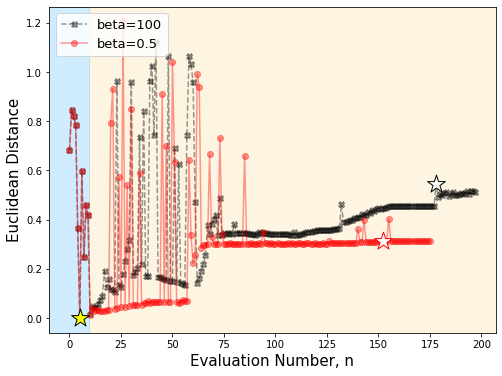

In [134]:
# Euclidean distance
def encode(arr, x_max = 34):
    x_arr = arr
    x_arr[0] = arr[0] + arr[1]
    if arr[0] + arr[1] == 0:
        x_arr[1] = 0.5
    else:
        x_arr[1] = arr[0] / (arr[0] + arr[1])
    x_arr[2] = arr[2] + arr[3]
    if arr[2] + arr[3] == 0:
        x_arr[3] = 0.5
    else:
        x_arr[3] = arr[2] / (arr[2] + arr[3])
    x_arr[4] = arr[4] / x_max
    return x_arr

def Euc_dist(X,Y):
    sum = 0
    for x, y in zip(X,Y):
        sum += (x-y)**2
    return np.sqrt(sum)
        
DATA_DEST = "../saved_data/UV_log_shuffled_10initial_test2_beta=100.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test2.csv"
df = pd.read_csv(DATA_DEST)
df_0p5 = pd.read_csv(DATA_DEST2)

best_init_1 = df.iloc[:10].nlargest(1,'UV').to_numpy()[0,:5]
best_init_1 = encode(best_init_1)
best_init_2 = df_0p5.iloc[:10].nlargest(1,'UV').to_numpy()[0,:5]
best_init_2 = encode(best_init_2)

evalued1 = len(df)
distance_1 = []
for i in range(evalued1):
    temp = df.iloc[i].to_numpy()[:5]
    temp = encode(temp)
    dist = Euc_dist(temp, best_init_1)
    distance_1.append(dist)
evalued2 = len(df_0p5)
distance_2 = []
for i in range(evalued2):
    temp = df_0p5.iloc[i].to_numpy()[:5]
    temp = encode(temp)
    dist = Euc_dist(temp, best_init_2)
    distance_2.append(dist)
    
x_1 = range(len(df))
y = distance_1
x_2 = range(len(df_0p5))
y_2 = distance_2

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_1, y, linestyle='dashed', c='black', alpha = 0.4, marker='X',label='beta=100')
ax1.plot(x_2, y_2, linestyle='solid', c='r', alpha = 0.4, marker='o', label='beta=0.5')
ax1.legend(loc = 'upper left', ncol=1, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('Euclidean Distance', fontsize = FontSize)

# ax1.set_ylim(0,40)
x = range(max(len(x_1),len(x_2)))
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])

# add best points
best_init = df.iloc[:10].UV.idxmax()
plt.scatter(x[best_init],y[best_init],marker='*',s=350,facecolors='yellow', edgecolors='black', zorder=3)
best_rec = df.iloc[10:].UV.idxmax()
plt.scatter(x[best_rec],y[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
best_rec_2 = df_0p5.iloc[10:].UV.idxmax()
plt.scatter(x_2[best_rec_2],y_2[best_rec_2],marker='*',s=350,facecolors='white', edgecolors='red', zorder=4)
plt.show()



In [135]:
y_2[best_rec_2] - y[best_rec]

-0.2340874408721672

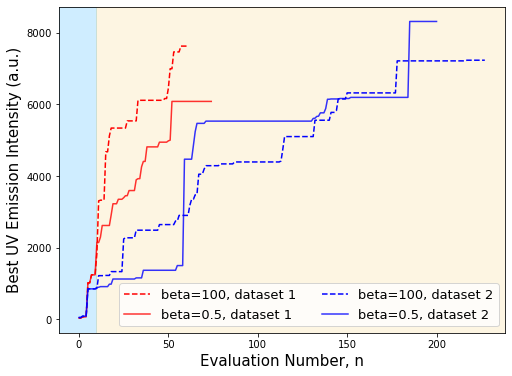

In [8]:
# two datasets in one figure
DATA_DEST1 = "../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test1.csv"
DATA_DEST3 = "../saved_data/UV_log_shuffled_10initial_test2_beta=100.csv"
DATA_DEST4 = "../saved_data/UV_log_shuffled_10initial_test2.csv"

df1 = pd.read_csv(DATA_DEST1)
df2 = pd.read_csv(DATA_DEST2)
df3 = pd.read_csv(DATA_DEST3)
df4 = pd.read_csv(DATA_DEST4)

#df_recommend = df.drop(range(1,620))
evalued1 = len(df1)
max_uv1 = []
y1 = df1.UV
x1 = range(len(y1)) 

evalued2 = len(df2)
max_uv2 = []
y2 = df2.UV
x2 = range(len(y2)) 

evalued3 = len(df3)
max_uv3 = []
y3 = df3.UV
x3 = range(len(y3)) 

evalued4 = len(df4)
max_uv4 = []
y4 = df4.UV
x4 = range(len(y4)) 


for i in range(evalued1):
    max_uv1.append(df1.iloc[0:i+1].UV.max())
for i in range(evalued2):
    max_uv2.append(df2.iloc[0:i+1].UV.max()) 
for i in range(evalued3):
    max_uv3.append(df3.iloc[0:i+1].UV.max())
for i in range(evalued4):
    max_uv4.append(df4.iloc[0:i+1].UV.max())

fig, ax2 = plt.subplots(figsize=(8, 6))
#ax2 = ax1.twinx()

#s1=ax1.scatter(x1, y1, facecolors='none', edgecolors='black', alpha = 1, marker='o', label='beta=100')
l1=ax2.plot(x1, max_uv1, c='r', alpha = 1, linestyle='dashed',label='beta=100, dataset 1')
#s2=ax1.scatter(x2, y2, c='black', alpha = 0.3, label='beta=0.5')
l2=ax2.plot(x2, max_uv2, c='r', alpha = 0.8, label='beta=0.5, dataset 1')
#s3=ax1.scatter(x3, y3, facecolors='none', edgecolors='black', alpha = 1, marker='o', label='beta=100')
l3=ax2.plot(x3, max_uv3, c='b', alpha = 1, linestyle='dashed',label='beta=100, dataset 2')
#s4=ax1.scatter(x4, y4, c='black', alpha = 0.3, label='beta=0.5')
l4=ax2.plot(x4, max_uv4, c='b', alpha = 0.8, label='beta=0.5, dataset 2')


FontSize = 15

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper left', ncol=2, fontsize = 13, frameon = True)
ax2.legend(loc='lower right', ncol=2, fontsize = 13, frameon = True)

# ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
# ax1.set_ylabel('UV Emission Intensity (a.u.)', fontsize = FontSize)
# ax2.set_ylabel('Best UV Emission Intensity (a.u.)', color='r', fontsize = FontSize)
ax2.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission Intensity (a.u.)', fontsize = FontSize)

x = range(max(len(x1),len(x2),len(x3),len(x4)))
#plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


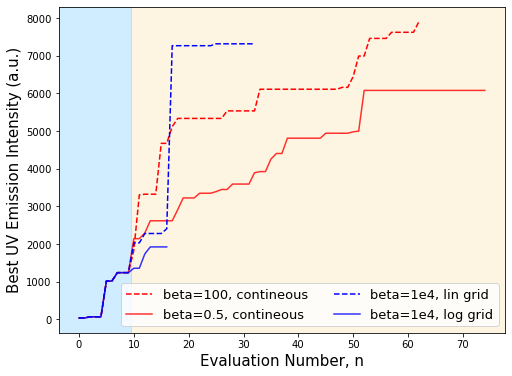

In [9]:
# two datasets in one figure
DATA_DEST1 = "../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test1.csv"
DATA_DEST3 = "../saved_data/UV_log_shuffled_10initial_test1_grid_beta=10000.csv"
DATA_DEST4 = "../saved_data/UV_log_shuffled_10initial_test1_loggrid_beta=10000.csv"

df1 = pd.read_csv(DATA_DEST1)
df2 = pd.read_csv(DATA_DEST2)
df3 = pd.read_csv(DATA_DEST3)
df4 = pd.read_csv(DATA_DEST4)

#df_recommend = df.drop(range(1,620))
evalued1 = len(df1)
max_uv1 = []
y1 = df1.UV
x1 = range(len(y1)) 

evalued2 = len(df2)
max_uv2 = []
y2 = df2.UV
x2 = range(len(y2)) 

evalued3 = len(df3)
max_uv3 = []
y3 = df3.UV
x3 = range(len(y3)) 

evalued4 = len(df4)
max_uv4 = []
y4 = df4.UV
x4 = range(len(y4)) 


for i in range(evalued1):
    max_uv1.append(df1.iloc[0:i+1].UV.max())
for i in range(evalued2):
    max_uv2.append(df2.iloc[0:i+1].UV.max()) 
for i in range(evalued3):
    max_uv3.append(df3.iloc[0:i+1].UV.max())
for i in range(evalued4):
    max_uv4.append(df4.iloc[0:i+1].UV.max())

fig, ax2 = plt.subplots(figsize=(8, 6))
#ax2 = ax1.twinx()

#s1=ax1.scatter(x1, y1, facecolors='none', edgecolors='black', alpha = 1, marker='o', label='beta=100')
l1=ax2.plot(x1, max_uv1, c='r', alpha = 1, linestyle='dashed',label='beta=100, contineous')
#s2=ax1.scatter(x2, y2, c='black', alpha = 0.3, label='beta=0.5')
l2=ax2.plot(x2, max_uv2, c='r', alpha = 0.8, label='beta=0.5, contineous')
#s3=ax1.scatter(x3, y3, facecolors='none', edgecolors='black', alpha = 1, marker='o', label='beta=100')
l3=ax2.plot(x3, max_uv3, c='b', alpha = 1, linestyle='dashed',label='beta=1e4, lin grid')
#s4=ax1.scatter(x4, y4, c='black', alpha = 0.3, label='beta=0.5')
l4=ax2.plot(x4, max_uv4, c='b', alpha = 0.8, label='beta=1e4, log grid')


FontSize = 15

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper left', ncol=2, fontsize = 13, frameon = True)
ax2.legend(loc='lower right', ncol=2, fontsize = 13, frameon = True)

# ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
# ax1.set_ylabel('UV Emission Intensity (a.u.)', fontsize = FontSize)
# ax2.set_ylabel('Best UV Emission Intensity (a.u.)', color='r', fontsize = FontSize)
ax2.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission Intensity (a.u.)', fontsize = FontSize)

x = range(max(len(x1),len(x2),len(x3),len(x4)))
#plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


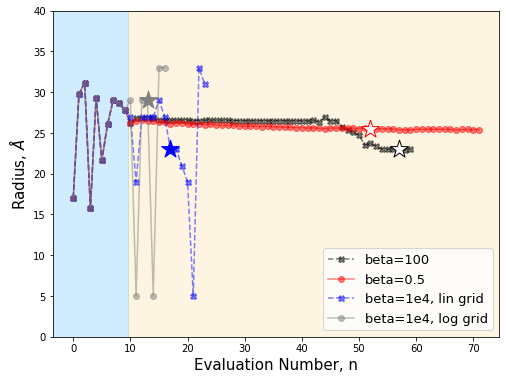

In [18]:
# optimization progress: recommended shell dopants
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test1.csv"
DATA_DEST3 = "../saved_data/UV_log_shuffled_10initial_test1_grid_beta=10000.csv"
DATA_DEST4 = "../saved_data/UV_log_shuffled_10initial_test1_loggrid_beta=10000.csv"
df1 = pd.read_csv(DATA_DEST1)
df2 = pd.read_csv(DATA_DEST2)
df3 = pd.read_csv(DATA_DEST3)
df4 = pd.read_csv(DATA_DEST4)

obj = 'radius'
y_1 = df1[obj]
y_2 = df2[obj]
y_3 = df3[obj]
y_4 = df4[obj]
x_1 = range(len(y_1))
x_2 = range(len(y_2))
x_3 = range(len(y_3))
x_4 = range(len(y_4))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_1, y_1, linestyle='dashed', c='black', alpha = 0.5, marker='X',label='beta=100')
ax1.plot(x_2, y_2, linestyle='solid', c='r', alpha = 0.5, marker='o', label='beta=0.5')
ax1.plot(x_3, y_3, linestyle='dashed', c='b', alpha = 0.5, marker='X',label='beta=1e4, lin grid')
ax1.plot(x_4, y_4, linestyle='solid', c='grey', alpha = 0.5, marker='o', label='beta=1e4, log grid')
ax1.legend(loc = 'lower right', ncol=1, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel(r'Radius, $\AA$', fontsize = FontSize)

ax1.set_ylim(0,40)
x = range(max(len(x_1),len(x_2),len(x_3),len(x_4)))
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])

# add best points
# best_init = df1.iloc[:10].UV.idxmax()
# plt.scatter(x_1[best_init],y_1[best_init],marker='*',s=350,facecolors='yellow', edgecolors='black', zorder=3)
best_rec = df1.iloc[10:].UV.idxmax()
plt.scatter(x_1[best_rec],y_1[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
best_rec_2 = df2.iloc[10:].UV.idxmax()
plt.scatter(x_2[best_rec_2],y_2[best_rec_2],marker='*',s=350,facecolors='white', edgecolors='red', zorder=4)
best_rec_3 = df3.iloc[10:].UV.idxmax()
plt.scatter(x_3[best_rec_3],y_3[best_rec_3],marker='*',s=350,facecolors='b', edgecolors='b', zorder=4)
best_rec_4 = df4.iloc[10:].UV.idxmax()
plt.scatter(x_4[best_rec_4],y_4[best_rec_4],marker='*',s=350,facecolors='grey', edgecolors='grey', zorder=4)
plt.show()
plt.show()


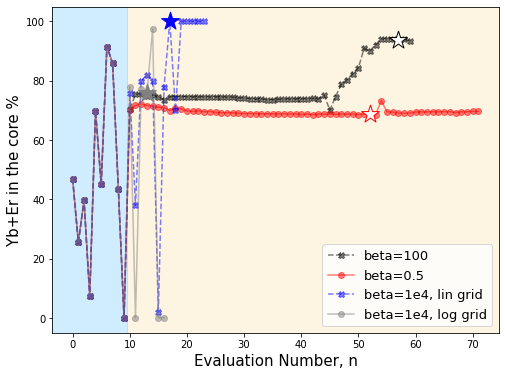

In [24]:
# optimization progress: recommended shell dopants
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test1.csv"
DATA_DEST3 = "../saved_data/UV_log_shuffled_10initial_test1_grid_beta=10000.csv"
DATA_DEST4 = "../saved_data/UV_log_shuffled_10initial_test1_loggrid_beta=10000.csv"
df1 = pd.read_csv(DATA_DEST1)
df2 = pd.read_csv(DATA_DEST2)
df3 = pd.read_csv(DATA_DEST3)
df4 = pd.read_csv(DATA_DEST4)

obj1 = 'yb_1'
obj2 = 'er_1'

y_1 = (df1[obj1]+df1[obj2])*100
y_2 = (df2[obj1]+df2[obj2])*100
y_3 = (df3[obj1]+df3[obj2])*100
y_4 = (df4[obj1]+df4[obj2])*100
x_1 = range(len(y_1))
x_2 = range(len(y_2))
x_3 = range(len(y_3))
x_4 = range(len(y_4))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_1, y_1, linestyle='dashed', c='black', alpha = 0.5, marker='X',label='beta=100')
ax1.plot(x_2, y_2, linestyle='solid', c='r', alpha = 0.5, marker='o', label='beta=0.5')
ax1.plot(x_3, y_3, linestyle='dashed', c='b', alpha = 0.5, marker='X',label='beta=1e4, lin grid')
ax1.plot(x_4, y_4, linestyle='solid', c='grey', alpha = 0.5, marker='o', label='beta=1e4, log grid')
ax1.legend(loc = 'lower right', ncol=1, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel(r'Yb+Er in the core %', fontsize = FontSize)

#ax1.set_ylim(0,40)
x = range(max(len(x_1),len(x_2),len(x_3),len(x_4)))
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])

# add best points
# best_init = df1.iloc[:10].UV.idxmax()
# plt.scatter(x_1[best_init],y_1[best_init],marker='*',s=350,facecolors='yellow', edgecolors='black', zorder=3)
best_rec = df1.iloc[10:].UV.idxmax()
plt.scatter(x_1[best_rec],y_1[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
best_rec_2 = df2.iloc[10:].UV.idxmax()
plt.scatter(x_2[best_rec_2],y_2[best_rec_2],marker='*',s=350,facecolors='white', edgecolors='red', zorder=4)
best_rec_3 = df3.iloc[10:].UV.idxmax()
plt.scatter(x_3[best_rec_3],y_3[best_rec_3],marker='*',s=350,facecolors='b', edgecolors='b', zorder=4)
best_rec_4 = df4.iloc[10:].UV.idxmax()
plt.scatter(x_4[best_rec_4],y_4[best_rec_4],marker='*',s=350,facecolors='grey', edgecolors='grey', zorder=4)
plt.show()
plt.show()


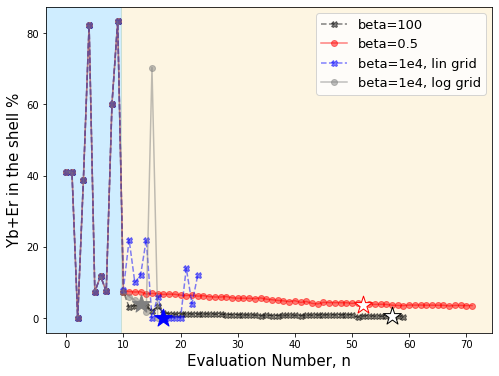

In [23]:
# optimization progress: recommended shell dopants
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test1.csv"
DATA_DEST3 = "../saved_data/UV_log_shuffled_10initial_test1_grid_beta=10000.csv"
DATA_DEST4 = "../saved_data/UV_log_shuffled_10initial_test1_loggrid_beta=10000.csv"
df1 = pd.read_csv(DATA_DEST1)
df2 = pd.read_csv(DATA_DEST2)
df3 = pd.read_csv(DATA_DEST3)
df4 = pd.read_csv(DATA_DEST4)

obj1 = 'yb_2'
obj2 = 'er_2'

y_1 = (df1[obj1]+df1[obj2])*100
y_2 = (df2[obj1]+df2[obj2])*100
y_3 = (df3[obj1]+df3[obj2])*100
y_4 = (df4[obj1]+df4[obj2])*100
x_1 = range(len(y_1))
x_2 = range(len(y_2))
x_3 = range(len(y_3))
x_4 = range(len(y_4))

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_1, y_1, linestyle='dashed', c='black', alpha = 0.5, marker='X',label='beta=100')
ax1.plot(x_2, y_2, linestyle='solid', c='r', alpha = 0.5, marker='o', label='beta=0.5')
ax1.plot(x_3, y_3, linestyle='dashed', c='b', alpha = 0.5, marker='X',label='beta=1e4, lin grid')
ax1.plot(x_4, y_4, linestyle='solid', c='grey', alpha = 0.5, marker='o', label='beta=1e4, log grid')
ax1.legend(loc = 'upper right', ncol=1, fontsize = 13, frameon = True)


FontSize = 15
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel(r'Yb+Er in the shell %', fontsize = FontSize)

#ax1.set_ylim(0,40)
x = range(max(len(x_1),len(x_2),len(x_3),len(x_4)))
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])

# add best points
# best_init = df1.iloc[:10].UV.idxmax()
# plt.scatter(x_1[best_init],y_1[best_init],marker='*',s=350,facecolors='yellow', edgecolors='black', zorder=3)
best_rec = df1.iloc[10:].UV.idxmax()
plt.scatter(x_1[best_rec],y_1[best_rec],marker='*',s=350,facecolors='white', edgecolors='black', zorder=4)
best_rec_2 = df2.iloc[10:].UV.idxmax()
plt.scatter(x_2[best_rec_2],y_2[best_rec_2],marker='*',s=350,facecolors='white', edgecolors='red', zorder=4)
best_rec_3 = df3.iloc[10:].UV.idxmax()
plt.scatter(x_3[best_rec_3],y_3[best_rec_3],marker='*',s=350,facecolors='b', edgecolors='b', zorder=4)
best_rec_4 = df4.iloc[10:].UV.idxmax()
plt.scatter(x_4[best_rec_4],y_4[best_rec_4],marker='*',s=350,facecolors='grey', edgecolors='grey', zorder=4)
plt.show()
plt.show()


In [32]:
df1.iloc[best_rec]

yb_1              0.887406
er_1              0.050455
yb_2              0.004589
er_2              0.000131
radius           23.010416
UV             7624.998955
VIS           12418.748276
BLUE           1937.499721
GREEN          3137.499555
RED            5699.999233
TOTAL         20674.997125
ABSORPTION    57437.491643
qe                0.014633
Name: 57, dtype: float64

In [ ]:
DATA_DEST = "../saved_data/UV_log_shuffled_10initial_test1_grid_beta=10000.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test1_loggrid_beta=10000.csv"

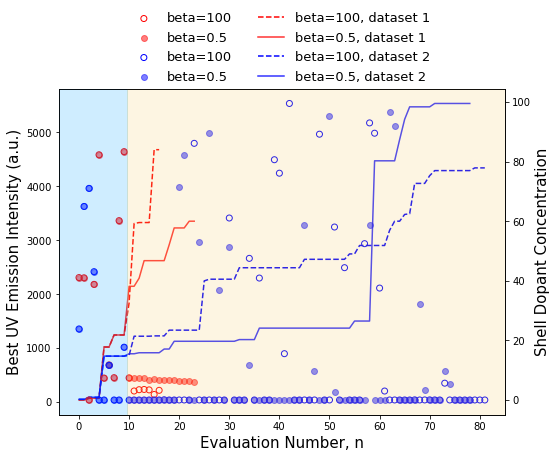

In [384]:
# two datasets in one figure
DATA_DEST1 = "../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test1.csv"
DATA_DEST3 = "../saved_data/UV_log_shuffled_10initial_test2_beta=100.csv"
DATA_DEST4 = "../saved_data/UV_log_shuffled_10initial_test2.csv"

df1 = pd.read_csv(DATA_DEST1)
df2 = pd.read_csv(DATA_DEST2)
df3 = pd.read_csv(DATA_DEST3)
df4 = pd.read_csv(DATA_DEST4)

obj1 = 'yb_2'
obj2 = 'er_2'

evalued1 = len(df1)
max_uv1 = []
y1 = (df1[obj1]+df1[obj2])*100
x1 = range(len(y1)) 

evalued2 = len(df2)
max_uv2 = []
y2 = (df2[obj1]+df2[obj2])*100
x2 = range(len(y2)) 

evalued3 = len(df3)
max_uv3 = []
y3 = (df3[obj1]+df3[obj2])*100
x3 = range(len(y3)) 

evalued4 = len(df4)
max_uv4 = []
y4 = (df4[obj1]+df4[obj2])*100
x4 = range(len(y4)) 


for i in range(evalued1):
    max_uv1.append(df1.iloc[0:i+1].UV.max())
for i in range(evalued2):
    max_uv2.append(df2.iloc[0:i+1].UV.max()) 
for i in range(evalued3):
    max_uv3.append(df3.iloc[0:i+1].UV.max())
for i in range(evalued4):
    max_uv4.append(df4.iloc[0:i+1].UV.max())

fig, ax2 = plt.subplots(figsize=(8, 6))
ax1 = ax2.twinx()

s1=ax1.scatter(x1, y1, facecolors='none', edgecolors='r', alpha = 1, marker='o', label='beta=100')
l1=ax2.plot(x1, max_uv1, c='r', alpha = 1, linestyle='dashed',label='beta=100, dataset 1')
s2=ax1.scatter(x2, y2, c='r', alpha = 0.5, label='beta=0.5')
l2=ax2.plot(x2, max_uv2, c='r', alpha = 0.8, label='beta=0.5, dataset 1')
s3=ax1.scatter(x3, y3, facecolors='none', edgecolors='b', alpha = 1, marker='o', label='beta=100')
l3=ax2.plot(x3, max_uv3, c='b', alpha = 1, linestyle='dashed',label='beta=100, dataset 2')
s4=ax1.scatter(x4, y4, c='b', alpha = 0.5, label='beta=0.5')
l4=ax2.plot(x4, max_uv4, c='b', alpha = 0.8, label='beta=0.5, dataset 2')


FontSize = 15

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=(0.15,1), ncol=2, fontsize = 13, frameon = False)
#ax2.legend(loc='lower right', ncol=2, fontsize = 13, frameon = True)

# ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('Shell Dopant Concentration', fontsize = FontSize)
# ax2.set_ylabel('Best UV Emission Intensity (a.u.)', color='r', fontsize = FontSize)
ax2.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission Intensity (a.u.)', fontsize = FontSize)

x = range(max(len(x1),len(x2),len(x3),len(x4)))
#plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


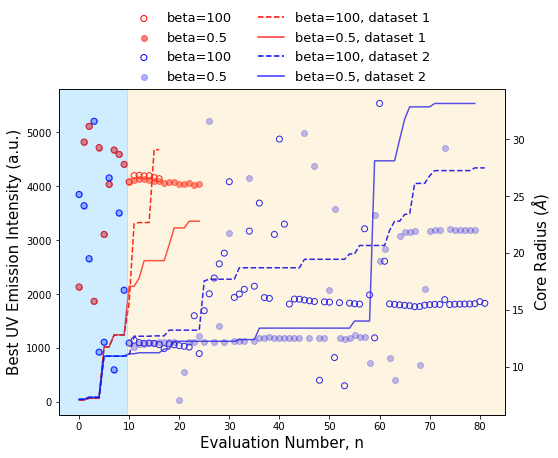

In [445]:
# two datasets in one figure
DATA_DEST1 = "../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test1.csv"
DATA_DEST3 = "../saved_data/UV_log_shuffled_10initial_test2_beta=100.csv"
DATA_DEST4 = "../saved_data/UV_log_shuffled_10initial_test2.csv"

df1 = pd.read_csv(DATA_DEST1)
df2 = pd.read_csv(DATA_DEST2)
df3 = pd.read_csv(DATA_DEST3)
df4 = pd.read_csv(DATA_DEST4)

obj = 'radius'
#df_recommend = df.drop(range(1,620))
evalued1 = len(df1)
max_uv1 = []
y1 = df1[obj]
x1 = range(len(y1)) 

evalued2 = len(df2)
max_uv2 = []
y2 = df2[obj]
x2 = range(len(y2)) 

evalued3 = len(df3)
max_uv3 = []
y3 = df3[obj]
x3 = range(len(y3)) 

evalued4 = len(df4)
max_uv4 = []
y4 = df4[obj]
x4 = range(len(y4)) 


for i in range(evalued1):
    max_uv1.append(df1.iloc[0:i+1].UV.max())
for i in range(evalued2):
    max_uv2.append(df2.iloc[0:i+1].UV.max()) 
for i in range(evalued3):
    max_uv3.append(df3.iloc[0:i+1].UV.max())
for i in range(evalued4):
    max_uv4.append(df4.iloc[0:i+1].UV.max())

fig, ax2 = plt.subplots(figsize=(8, 6))
ax1 = ax2.twinx()

s1=ax1.scatter(x1, y1, facecolors='none', edgecolors='r', alpha = 1, marker='o', label='beta=100')
l1=ax2.plot(x1, max_uv1, c='r', alpha = 1, linestyle='dashed',label='beta=100, dataset 1')
s2=ax1.scatter(x2, y2, c='r', alpha = 0.5, label='beta=0.5')
l2=ax2.plot(x2, max_uv2, c='r', alpha = 0.8, label='beta=0.5, dataset 1')
s3=ax1.scatter(x3, y3, facecolors='none', edgecolors='b', alpha = 1, marker='o', label='beta=100')
l3=ax2.plot(x3, max_uv3, c='b', alpha = 1, linestyle='dashed',label='beta=100, dataset 2')
s4=ax1.scatter(x4, y4, c='b', alpha = 0.3, label='beta=0.5')
l4=ax2.plot(x4, max_uv4, c='b', alpha = 0.8, label='beta=0.5, dataset 2')


FontSize = 15

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=(0.15,1), ncol=2, fontsize = 13, frameon = False)
#ax2.legend(loc='lower right', ncol=2, fontsize = 13, frameon = True)

# ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel(r'Core Radius ($\AA$)', fontsize = FontSize)
# ax2.set_ylabel('Best UV Emission Intensity (a.u.)', color='r', fontsize = FontSize)
ax2.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission Intensity (a.u.)', fontsize = FontSize)

x = range(max(len(x1),len(x2),len(x3),len(x4)))
#plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


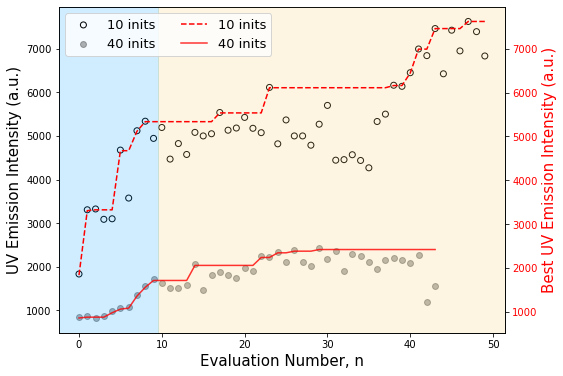

In [43]:
# optimization progress: result of each iteration and best results
# to compare optimizations with the same initial dataset but different beta values
DATA_DEST = "../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv"
DATA_DEST2 = "../saved_data/UV_log_KS_40initial_linscale.csv"
df = pd.read_csv(DATA_DEST)
df_0p5 = pd.read_csv(DATA_DEST2)

evalued = len(df)-10
max_uv = []
y = df.iloc[10:].UV

evalued_2 = len(df_0p5)-40
max_uv_2 = []
y_2 = df_0p5.iloc[40:i+1].UV

for i in range(evalued):
    max_uv.append(df.iloc[10:10+i+1].UV.max())
x = range(len(max_uv))   

for i in range(evalued_2):
    max_uv_2.append(df_0p5.iloc[40:40+i+1].UV.max())
x_2 = range(len(max_uv_2)) 

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

s1=ax1.scatter(x, y, facecolors='none', edgecolors='black', alpha = 1, marker='o', label='10 inits')
l1=ax2.plot(x, max_uv, c='r', alpha = 1, linestyle='dashed',label='10 inits')
s2=ax1.scatter(x_2, y_2, c='black', alpha = 0.3, label='40 inits')
l2=ax2.plot(x_2, max_uv_2, c='r', alpha = 0.8, label='40 inits')

FontSize = 15

# Ask matplotlib for the plotted objects and their labels. 
# This is to make labels of ax1 and ax2 show in one legend.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', ncol=2, fontsize = 13, frameon = True)


ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity (a.u.)', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission Intensity (a.u.)', color='r', fontsize = FontSize)

#ax2.tick_params(axis='y', color='r')
#ax2.spines['right'].set_color('red') 
#plt.setp(ax2.get_yticklabels(), visible=False)
x = range(max(len(x),len(x_2)))
plt.setp(ax2.get_yticklabels(), color="red")
plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([x[0]-x[-1]*0.05,x[-1]+x[-1]*0.05])
plt.show()


In [42]:
len(x)

60

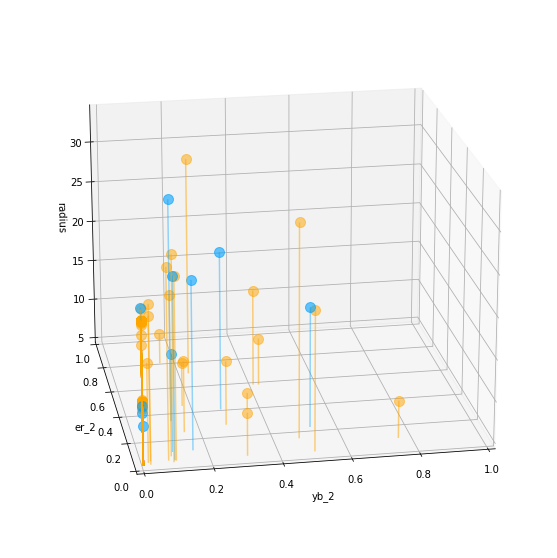

In [635]:
# plot 3D
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

DATA_DEST1 = "../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test1.csv"
DATA_DEST3 = "../saved_data/UV_log_shuffled_10initial_test2_beta=100.csv"
DATA_DEST4 = "../saved_data/UV_log_shuffled_10initial_test2.csv"

df1 = pd.read_csv(DATA_DEST1)
df2 = pd.read_csv(DATA_DEST2)
df3 = pd.read_csv(DATA_DEST3)
df4 = pd.read_csv(DATA_DEST4)

df_crt = df4
init = df_crt.iloc[:10]
rec = df_crt.iloc[10:]


fig,ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})

markerline, stemlines, baseline = ax.stem(rec.yb_2, rec.er_2, rec.radius,
             linefmt='orange', basefmt=' ',bottom=5)
stemlines.set_alpha(0.5)
markerline.set_color('orange')
markerline.set_alpha(0.5)
markerline.set_markersize('10')

markerline2, stemlines2, baseline2 = ax.stem(init.yb_2, init.er_2, init.radius,
             linefmt='#00A1FF', basefmt=' ',bottom=5)
stemlines2.set_alpha(0.4)
markerline2.set_color('#00A1FF')
markerline2.set_alpha(0.6)
markerline2.set_markersize('10')

ax.view_init(20,260)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([5,34])
ax.set_xlabel('yb_2')
ax.set_ylabel('er_2')
ax.set_zlabel('radius')
plt.show()

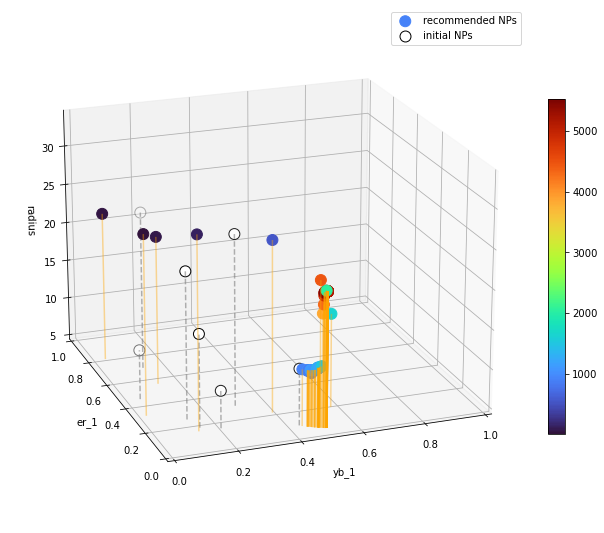

In [718]:
from matplotlib import cm

cmap = cm.get_cmap('turbo')
from mpl_toolkits.axes_grid1 import make_axes_locatable

init = df_crt.iloc[:10] 
rec = df_crt.iloc[10:]
my_color=rec.UV

fig,ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})
p = ax.scatter(rec.yb_1, rec.er_1, rec.radius, c=my_color, cmap=cmap, s=120,alpha=1,label='recommended NPs')

markerline, stemlines, baseline = ax.stem(rec.yb_1, rec.er_1, rec.radius,
                                         linefmt='orange', basefmt=' ',bottom=5)
stemlines.set_alpha(0.4)
markerline.set_color('orange')
markerline.set_alpha(0.5)
markerline.set_markersize(0)

ax.scatter(init.yb_1, init.er_1, init.radius,facecolors='white', edgecolors='black', cmap=cmap, s=120, label='initial NPs')
markerline2, stemlines2, baseline2 = ax.stem(init.yb_1, init.er_1, init.radius,linefmt='grey', basefmt=' ',bottom=5)

stemlines2.set_alpha(0.6)
stemlines2.set_linestyle('dashed')
markerline2.set_markersize(0)


ax.view_init(20,250)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([5,34])
ax.set_xlabel('yb_1')
ax.set_ylabel('er_1')
ax.set_zlabel('radius')
ax.legend()   
plt.colorbar(p, ax=ax, fraction=0.03, pad=0.04)
plt.show()


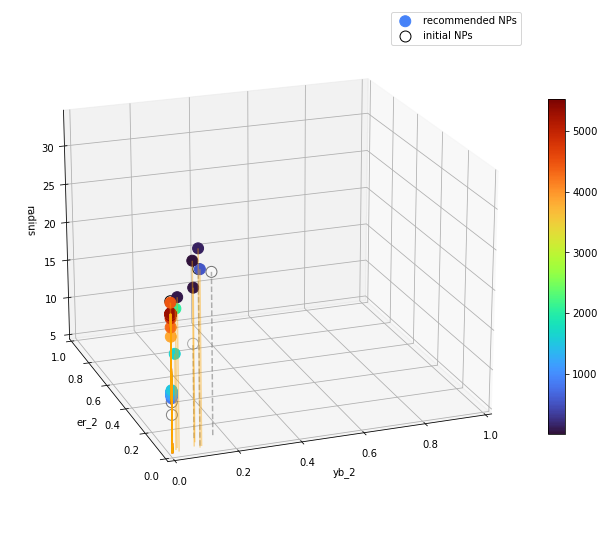

In [717]:
# shell
from matplotlib import cm

cmap = cm.get_cmap('turbo')
from mpl_toolkits.axes_grid1 import make_axes_locatable

init = df_crt.iloc[:10] 
rec = df_crt.iloc[10:]
my_color=rec.UV

fig,ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})
p = ax.scatter(rec.yb_2, rec.er_2, rec.radius, c=my_color, cmap=cmap, s=120,alpha=1,label='recommended NPs')

markerline, stemlines, baseline = ax.stem(rec.yb_2, rec.er_2, rec.radius,
                                         linefmt='orange', basefmt=' ',bottom=5)
stemlines.set_alpha(0.4)
markerline.set_color('orange')
markerline.set_alpha(0.5)
markerline.set_markersize(1)

ax.scatter(init.yb_2, init.er_2, init.radius,facecolors='white', edgecolors='black', cmap=cmap, s=120, label='initial NPs')
markerline2, stemlines2, baseline2 = ax.stem(init.yb_2, init.er_2, init.radius,linefmt='grey', basefmt=' ',bottom=5)

stemlines2.set_alpha(0.6)
stemlines2.set_linestyle('dashed')
markerline2.set_markersize(0)


ax.view_init(20,250)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([5,34])
ax.set_xlabel('yb_2')
ax.set_ylabel('er_2')
ax.set_zlabel('radius')
ax.legend()   
plt.colorbar(p, ax=ax, fraction=0.03, pad=0.04)
plt.show()


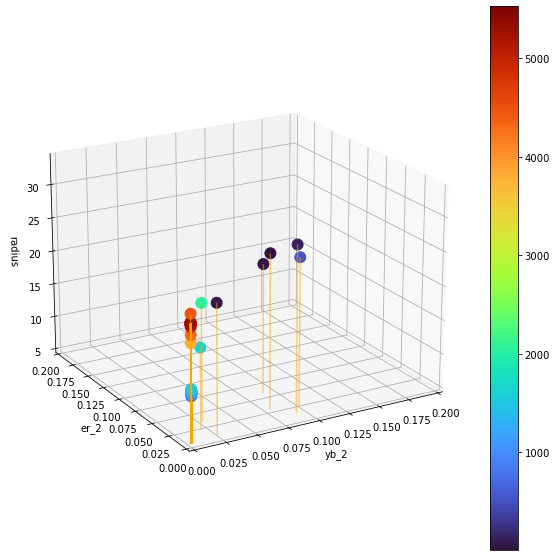

In [734]:
from matplotlib import cm
cmap = cm.get_cmap('turbo')
from mpl_toolkits.axes_grid1 import make_axes_locatable

# trim the data
rec = df_crt.iloc[10:] 
my_color=rec.UV
X = rec.yb_2.tolist()
Y = rec.er_2.tolist()
Z = rec.radius
for i in np.arange(len(X)):
    if X[i] > 0.2:
        X[i] = np.nan
        Y[i] = np.nan
        Z[i] = np.nan
    if Y[i] > 0.2:
        X[i] = np.nan
        Y[i] = np.nan
        Z[i] = np.nan
    else:
        pass

fig,ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': '3d'})
p = ax.scatter(X, Y, Z, c=my_color, cmap=cmap, s=120,alpha=1)

markerline, stemlines, baseline = ax.stem(X, Y, Z,
                                         linefmt='orange', basefmt=' ',bottom=5)
stemlines.set_alpha(0.5)
markerline.set_color('orange')
markerline.set_alpha(0.5)
markerline.set_markersize(1)

ax.view_init(20,240)
ax.set_xlim([0,0.2])
ax.set_ylim([0,0.2])
ax.set_zlim([5,34])
ax.set_xlabel('yb_2')
ax.set_ylabel('er_2')
ax.set_zlabel('radius')
plt.colorbar(p,ax=ax)
plt.show()


In [450]:
DATA_DEST1 = "../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv"
DATA_DEST2 = "../saved_data/UV_log_shuffled_10initial_test1.csv"
DATA_DEST3 = "../saved_data/UV_log_shuffled_10initial_test2_beta=100.csv"
DATA_DEST4 = "../saved_data/UV_log_shuffled_10initial_test2.csv"
#df = pd.read_csv(DATA_DEST4)

GSPREAD_CRED = './common/sustained-spark-354104-2f5a40769608.json'
GSPREAD_NAME = 'simulation_log.csv'
df = gcloud_utils.get_df_gspread(GSPREAD_CRED, GSPREAD_NAME)



best_np = df.nlargest(1,'UV')
best_np


,yb_1,er_1,yb_2,er_2,radius,UV,VIS,BLUE,GREEN,RED,TOTAL,ABSORPTION,qe
628,0.700027,0.009968,0.0,0.0,22.101665,8912.49914,6993.749316,1281.249879,1393.749857,1999.999804,16556.24838,82212.49203,0.021829


Text(0.5, 0, 'UV intensity')

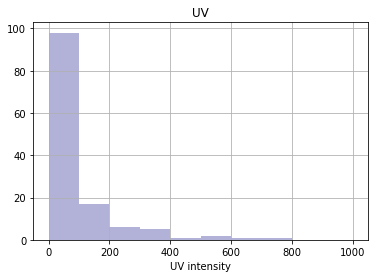

In [39]:
df_new = df.iloc[405:540]
df_new.hist(column = 'UV', color='navy', alpha =0.3, bins=[0,100,200,300,400,500,600,700,800,900,1000])
plt.xlabel('UV intensity')

Text(0.5, 0, 'UV intensity')

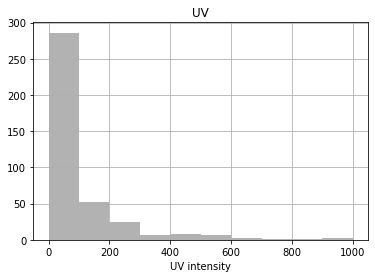

In [40]:
df_old = df.iloc[0:405]
df_old.hist(column = 'UV', color='black', alpha =0.3, bins=[0,100,200,300,400,500,600,700,800,900,1000])
plt.xlabel('UV intensity')